In [1]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras.callbacks import Callback
from datamodules import data_processors
from sklearn.preprocessing import StandardScaler
import sys
print(sys.version)

3.13.3 (main, Apr 22 2025, 00:00:00) [GCC 14.2.1 20250110 (Red Hat 14.2.1-7)]


In [2]:
N_archivos = 24
key_features = "x_"
path_rand = map(lambda x: "../input_data/cubic_" + str(x + 1) + ".csv", range(N_archivos))
datos_rand = [pd.read_csv(x) for x in path_rand]
path_to_current_model = "none" #"models/isotropico_act_custom_6.keras" # colocar "none" si quiere entrenar un modelo
if path_to_current_model == "none":
    new_model_path = "models/cubico_L5.keras"

In [3]:
class HistorySaverCallback(Callback):
    def __init__(self, filename=new_model_path[:-6] + "_save_history.csv"):
        super().__init__()
        self.filename = filename

        # Load existing history if file exists
        if os.path.exists(self.filename):
            self.history_df = pd.read_csv(self.filename)
        else:
            self.history_df = pd.DataFrame()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Append new row
        logs['epoch'] = epoch
        self.history_df = pd.concat([self.history_df, pd.DataFrame([logs])], ignore_index=True)

        # Save to CSV
        self.history_df.to_csv(self.filename, index=False)

In [4]:
datos_rand[23].head()

,phi_a,x_K,eta,beta,phi_K,eig_0,eig_1,eig_2,eig_3,eig_4,...,eig_13,eig_14,eig_15,eig_16,eig_17,eig_18,eig_19,Parallelepiped,Cylinder,Ellipsoid
0,0.159071,0.664884,0.620945,0.925625,0.843458,0.004932,1.876379,5.418913,10.949760,11.751771,...,93.465308,96.449061,98.380558,104.035805,124.377655,136.739105,139.924771,1,0,0
1,1.564936,0.850965,1.256859,0.225319,0.552977,0.000024,4.583693,9.642338,34.653417,36.881049,...,229.132184,312.493807,339.492041,375.828693,411.289816,438.355515,507.972917,1,0,0
2,1.004712,0.425741,1.389076,1.487684,1.131015,0.508619,1.227356,2.798865,3.048854,3.845909,...,10.456275,11.414851,11.668596,12.101428,13.266002,13.315124,14.897108,1,0,0
3,1.346369,0.277612,1.563983,2.470782,1.289488,1.253704,1.270076,1.693361,1.783931,1.808486,...,4.446236,4.500410,4.739940,4.880034,4.964918,5.477737,5.570458,1,0,0
4,0.740773,0.370656,0.276926,1.413281,1.191081,0.000955,6.657940,7.384144,14.920750,27.319266,...,346.573368,412.396562,499.846988,669.757854,923.975627,1632.844023,1804.017530,1,0,0


In [5]:
N_eig = 19
features = ["eta", "beta"] + list(map(lambda x: key_features + str(x), range(N_eig + 1)))
target = ["phi_a", "phi_K"]

In [6]:
datos_post = []
for datos in datos_rand:
    datos_post.append(data_processors.preprocess_data(datos, N_eig, target))
#fin for 
datos_rand = datos_post

In [7]:
total_datos = sum(map(lambda x: len(datos_rand[x]), range(len(datos_rand))))
print({"total datos": total_datos})

{'total datos': 1199822}


In [8]:
datos_rand[23].head()

,phi_a,phi_K,eig_0,eta,beta,eig_1,eig_2,eig_3,eig_4,eig_5,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
0,0.101268,0.536962,0.004932,0.620945,0.925625,0.532941,0.346265,0.494889,0.931754,0.689975,...,0.051889,0.071687,0.074599,0.041788,0.021324,0.013804,0.040416,0.145377,0.088344,0.022767
1,0.996269,0.352036,0.000024,1.256859,0.225319,0.218165,0.475372,0.278251,0.939600,0.660556,...,0.164255,0.007320,0.009852,0.011371,0.164106,0.053149,0.071533,0.069809,0.053282,0.137049
2,0.639620,0.720027,0.508619,1.389076,1.487684,0.814759,0.438519,0.918006,0.792752,0.808002,...,0.032276,0.088184,0.067878,0.088819,0.064346,0.017033,0.029055,0.078175,0.003297,0.106194
3,0.857125,0.820914,1.253704,1.563983,2.470782,0.787354,0.750033,0.949230,0.986423,0.787179,...,0.040877,0.002013,0.080337,0.007306,0.009725,0.043000,0.025150,0.015238,0.092061,0.016645
4,0.471591,0.758266,0.000955,0.276926,1.413281,0.150197,0.901654,0.494891,0.546162,0.646564,...,0.003597,0.038205,0.047675,0.029264,0.036487,0.048475,0.094185,0.140918,0.392939,0.094885


In [9]:
datos_rand[0].keys()

Index(['phi_a', 'phi_K', 'eig_0', 'eta', 'beta', 'eig_1', 'eig_2', 'eig_3',
       'eig_4', 'eig_5', 'eig_6', 'eig_7', 'eig_8', 'eig_9', 'eig_10',
       'eig_11', 'eig_12', 'eig_13', 'eig_14', 'eig_15', 'eig_16', 'eig_17',
       'eig_18', 'eig_19', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6',
       'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15',
       'x_16', 'x_17', 'x_18', 'x_19'],
      dtype='object')

In [10]:
#X_rand = pd.concat(datos_rand[x][features] for x in range(N_archivos))
#y_rand = pd.concat(datos_rand[x][target] for x in range(N_archivos))
datos_rand_full = pd.concat(datos_rand[x][target + features] for x in range(N_archivos))

In [11]:
datos_rand_full.head()

,phi_a,phi_K,eta,beta,x_0,x_1,x_2,x_3,x_4,x_5,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
0,0.201275,0.418536,0.754219,1.079462,0.010772,0.006780,0.036784,0.034800,0.009804,0.061399,...,0.037703,0.024283,0.019019,0.028045,0.038751,0.116162,0.064748,0.033305,0.060507,0.177081
1,0.103390,0.933089,0.828890,1.373335,0.020849,0.000995,0.060529,0.008283,0.031947,0.102965,...,0.038748,0.000157,0.023408,0.065450,0.059704,0.151051,0.001422,0.068996,0.095570,0.023104
2,0.863061,0.555632,0.841161,0.034810,0.001247,0.005424,0.003209,0.018292,0.003635,0.009327,...,0.026346,0.086333,0.053014,0.017997,0.018439,0.013681,0.210349,0.048250,0.376034,0.003080
3,0.353435,0.711329,1.474294,0.895600,0.025554,0.048857,0.047154,0.025056,0.033120,0.093392,...,0.026038,0.068974,0.010208,0.081517,0.040462,0.179597,0.017740,0.002207,0.109477,0.007541
4,0.027397,0.872739,0.605128,1.433838,0.010657,0.017148,0.028327,0.013437,0.046397,0.039468,...,0.019437,0.190799,0.057693,0.106439,0.063658,0.096491,0.062558,0.017111,0.003015,0.030302


In [12]:
train_frac = 0.7
val_frac = 0.15
test_frac = 0.15
datos_rand_shuffled = datos_rand_full.sample(frac = 1, random_state = 42)

In [13]:
n_tot = len(datos_rand_shuffled)
train_end = int(train_frac * n_tot)
val_end = train_end + int(val_frac * n_tot)
datos_train = datos_rand_shuffled.iloc[:train_end]
datos_val = datos_rand_shuffled.iloc[train_end:val_end]
datos_test = datos_rand_shuffled.iloc[val_end:]

In [14]:
print("Train: ", len(datos_train))
print("Val: ", len(datos_val))
print("Test: ", len(datos_test))

Train:  839875
Val:  179973
Test:  179974


In [15]:
X_train = datos_train[features]
y_train = datos_train[target]
X_val = datos_val[features]
y_val = datos_val[target]
X_test = datos_test[features]
y_test = datos_test[target]

In [16]:
X_train.head()

,eta,beta,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
41930,0.590002,2.912177,0.009907,0.002036,0.051727,0.002575,0.007347,0.029639,0.100758,0.023974,...,0.109049,0.008605,0.042910,0.235928,0.097822,0.019899,0.002534,0.032645,0.040044,0.001802
45056,1.562468,0.906315,0.043674,0.014537,0.013731,0.118180,0.004784,0.075522,0.027880,0.037203,...,0.009048,0.017115,0.021116,0.094222,0.029332,0.035894,0.184420,0.026721,0.184559,0.018362
26602,1.209183,2.306984,0.043212,0.125149,0.026381,0.001625,0.012690,0.114460,0.054486,0.120326,...,0.069351,0.005021,0.027919,0.031574,0.020461,0.006306,0.109018,0.064198,0.050135,0.087727
47062,1.467972,2.484167,0.056699,0.122391,0.044627,0.023556,0.001214,0.020974,0.006109,0.067807,...,0.006675,0.011982,0.035436,0.096759,0.011013,0.001217,0.042863,0.072275,0.217797,0.007913
38590,1.409571,0.645659,0.013798,0.020790,0.082525,0.013999,0.014468,0.013946,0.064740,0.006721,...,0.047636,0.061295,0.025895,0.001080,0.088710,0.159432,0.003603,0.020009,0.115528,0.110753


In [17]:
X_train.describe()

,eta,beta,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
count,839875.000000,839875.000000,8.398750e+05,8.398750e+05,8.398750e+05,8.398750e+05,8.398750e+05,8.398750e+05,8.398750e+05,8.398750e+05,...,8.398750e+05,8.398750e+05,8.398750e+05,8.398750e+05,8.398750e+05,8.398750e+05,8.398750e+05,8.398750e+05,8.398750e+05,8.398750e+05
mean,1.187935,1.572076,4.493978e-02,3.716262e-02,3.413461e-02,3.998380e-02,3.060117e-02,3.732192e-02,3.961097e-02,5.121182e-02,...,4.989559e-02,5.514668e-02,5.209780e-02,5.658002e-02,5.851405e-02,5.576047e-02,6.074981e-02,6.346582e-02,7.259101e-02,7.308620e-02
std,0.460876,0.906629,5.354969e-02,4.233787e-02,3.000531e-02,3.900187e-02,3.174350e-02,3.596415e-02,3.753215e-02,5.163951e-02,...,4.939188e-02,5.004098e-02,4.787056e-02,5.054998e-02,5.393534e-02,5.472123e-02,6.341693e-02,6.497717e-02,7.296594e-02,7.644358e-02
min,0.001060,0.000288,8.399063e-08,1.479416e-09,5.062643e-09,1.259686e-07,9.313259e-09,1.180386e-08,2.201214e-08,5.164176e-08,...,2.054205e-08,5.575091e-08,5.612655e-08,7.396976e-08,1.811741e-08,3.753706e-08,7.537362e-08,1.151347e-07,2.246339e-08,7.346259e-09
25%,0.842445,0.787651,7.297764e-03,5.935400e-03,9.696335e-03,1.005998e-02,8.440662e-03,1.073081e-02,1.190017e-02,1.375986e-02,...,1.451779e-02,1.650307e-02,1.599088e-02,1.749326e-02,1.780777e-02,1.623755e-02,1.689218e-02,1.783525e-02,1.999429e-02,1.997069e-02
50%,1.234074,1.571926,2.627673e-02,1.943942e-02,2.569535e-02,2.713426e-02,2.112488e-02,2.581420e-02,2.867280e-02,3.461179e-02,...,3.476231e-02,4.033856e-02,3.806086e-02,4.227434e-02,4.293629e-02,3.923335e-02,4.073948e-02,4.319251e-02,4.964656e-02,4.912213e-02
75%,1.575243,2.358957,6.248441e-02,5.312414e-02,5.178530e-02,5.872846e-02,4.315075e-02,5.257955e-02,5.615588e-02,7.313897e-02,...,6.859268e-02,7.995081e-02,7.420107e-02,8.204895e-02,8.415824e-02,7.834743e-02,8.276551e-02,8.724708e-02,1.012415e-01,1.001105e-01
max,1.916371,3.141591,5.573791e-01,2.043037e-01,2.754396e-01,3.221161e-01,3.350139e-01,2.847290e-01,4.160416e-01,4.217046e-01,...,4.389721e-01,4.735820e-01,5.007318e-01,4.751074e-01,8.916921e-01,8.156763e-01,6.818820e-01,6.504951e-01,7.299909e-01,9.010690e-01


In [18]:
estadisticas = pd.DataFrame(X_train.describe())
if path_to_current_model == "none":
    estadisticas.to_csv(new_model_path[:-6] + "_stats.csv")

In [19]:
X_train = data_processors.scale(X_train)
X_train.head()

,eta,beta,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
41930,-1.297384,1.478115,-0.654204,-0.829684,0.586319,-0.959166,-0.732575,-0.213641,1.629204,-0.527471,...,1.197641,-0.930063,-0.191935,3.547931,0.728805,-0.655343,-0.917983,-0.474332,-0.446061,-0.932506
45056,0.812656,-0.734326,-0.023639,-0.534414,-0.680017,2.004933,-0.813321,1.062180,-0.312552,-0.271284,...,-0.827003,-0.760012,-0.647199,0.744645,-0.541054,-0.363044,1.950116,-0.565499,1.534525,-0.715878
26602,0.046103,0.810595,-0.032262,2.078194,-0.258423,-0.983514,-0.564240,2.144859,0.396339,1.338395,...,0.393904,-1.001691,-0.505097,-0.494687,-0.705538,-0.903747,0.761128,0.011270,-0.307756,0.191526
47062,0.607620,1.006025,0.219592,2.013066,0.349673,-0.421204,-0.925777,-0.454569,-0.892634,0.321360,...,-0.875052,-0.862597,-0.348065,0.794830,-0.880698,-0.996749,-0.282058,0.135568,1.990056,-0.852562
38590,0.480903,-1.021826,-0.581549,-0.386702,1.612723,-0.666245,-0.508231,-0.649984,0.669547,-0.861569,...,-0.045749,0.122863,-0.547372,-1.097928,0.559864,1.894544,-0.901134,-0.668803,0.588457,0.492734


In [20]:
X_val = data_processors.scale(X_val, estadisticas)
X_val.head()

,eta,beta,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
27831,0.884341,-0.563213,-0.154366,0.257319,-0.401862,0.941163,-0.884795,1.249869,-0.371478,-0.811046,...,-0.849303,-1.056624,-1.013758,0.545518,-0.785760,-0.608890,1.939953,-0.906637,1.013352,0.156804
31787,-0.056201,1.714318,0.195264,1.396849,-1.114193,0.947395,0.018367,-0.977559,1.671883,1.384305,...,-1.004659,-1.084140,0.650935,-0.914940,1.070593,-0.996686,2.405045,-0.745870,-0.772912,-0.935093
27279,-0.320113,0.271602,-0.112749,0.440814,-1.012939,1.255614,0.041534,2.698119,-0.754002,-0.874800,...,-0.606486,-0.469917,-0.741231,0.469954,-0.744107,1.204162,-0.784021,0.116212,-0.438881,-0.787821
3898,1.549112,-0.142839,0.604030,0.519414,-0.698542,0.011415,0.024957,1.203689,-0.857985,-0.209118,...,-0.398823,-0.418743,-0.590568,2.367049,0.735245,-0.873655,-0.933925,0.023971,-0.546168,0.373429
3399,-0.586558,-0.703100,-0.626542,-0.491713,0.590487,-0.549603,-0.361670,0.838146,-0.323845,0.055680,...,0.654286,1.642401,1.471706,-0.175395,0.316642,-0.149078,-0.874818,-0.617281,-0.308038,0.640656


In [21]:
X_test = data_processors.scale(X_test, estadisticas)
X_test.head()

,eta,beta,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
37032,-0.345768,-0.226274,-0.323030,-0.631126,1.015333,0.264133,-0.778575,0.592890,-0.157357,-0.154572,...,1.082587,0.765727,-0.000659,-1.033445,-0.704334,-0.817833,0.368874,-0.361846,0.464417,0.657067
41067,0.195668,0.977539,0.789875,-0.068598,0.602562,-0.398400,4.782997,-0.428677,-0.246902,-0.936085,...,-0.746649,-0.765136,-0.246721,1.324477,0.146058,0.868495,-0.829462,-0.682548,-0.693980,-0.334715
24579,0.810045,-0.139483,-0.253886,2.146677,0.623551,0.001654,-0.539040,-0.181598,-0.828105,0.161189,...,-0.212266,-0.934903,1.116812,0.617023,1.231718,-0.838402,-0.436644,-0.660367,-0.506519,-0.333755
31355,0.778354,-0.501455,-0.219367,0.190788,0.370819,-0.937875,-0.393171,-0.182259,2.021095,-0.374803,...,-0.551344,-0.201459,0.030479,-0.267019,4.597063,1.248013,-0.839274,-0.868313,-0.900024,-0.813211
32989,0.156066,0.195788,-0.217610,2.092441,-0.462950,-0.479841,-0.406265,3.584547,0.686759,-0.959272,...,-0.955534,0.078836,-0.973895,-0.978148,1.755096,-0.368041,-0.198457,-0.737887,-0.338053,-0.236235


In [21]:
corr_mat = datos_train.select_dtypes(include=['number']).corr()
print(corr_mat)

          phi_a     phi_K       eta      beta       x_0       x_1       x_2  \
phi_a  1.000000  0.001012  0.000808  0.001940  0.150395 -0.337165 -0.016743   
phi_K  0.001012  1.000000  0.000411 -0.000329  0.011818 -0.151644 -0.030804   
eta    0.000808  0.000411  1.000000 -0.000123  0.535122  0.489780  0.381569   
beta   0.001940 -0.000329 -0.000123  1.000000  0.580969  0.294793  0.116838   
x_0    0.150395  0.011818  0.535122  0.580969  1.000000  0.347216  0.274534   
x_1   -0.337165 -0.151644  0.489780  0.294793  0.347216  1.000000  0.125330   
x_2   -0.016743 -0.030804  0.381569  0.116838  0.274534  0.125330  1.000000   
x_3    0.107535 -0.028026  0.187257  0.357224  0.323683  0.005554 -0.028580   
x_4    0.089599  0.036087  0.105171  0.292979  0.306553  0.027094  0.111366   
x_5   -0.099891 -0.044277  0.190111 -0.071898 -0.009086  0.121721  0.127989   
x_6    0.085854  0.009293  0.026988  0.180293  0.016624  0.012877  0.081430   
x_7   -0.032686 -0.054411 -0.000303  0.269643  0.096

Text(0.5, 1.0, 'Correlation Matrix')

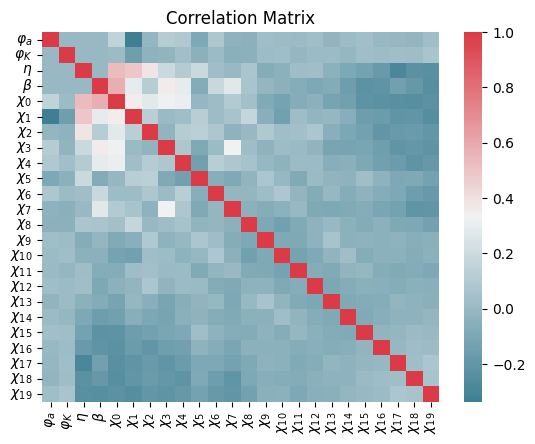

In [22]:
symbols_target = {"phi_a": r"$\varphi_a$", "phi_K": r"$\varphi_K$"}
symbols_comp = dict(map(lambda x: ("x_" + str(x), r"$\chi_{%d}$" % x), range(N_eig + 1)))
symbols_features = {**symbols_target, "eta": r"$\eta$", "beta": r"$\beta$", **symbols_comp}
sns.heatmap(corr_mat, cmap=sns.diverging_palette(220, 10, as_cmap=True), xticklabels = symbols_features.values(), yticklabels = symbols_features.values())
plt.title("Correlation Matrix")

In [23]:
torch.cuda.get_device_properties(torch.device("cuda"))

_CudaDeviceProperties(name='AMD Radeon RX 6600M', major=10, minor=3, gcnArchName='gfx1030', total_memory=8176MB, multi_processor_count=14, uuid=58580000-0000-0000-0000-000000000000, L2_cache_size=2MB)

In [24]:
def crear_modelo_de_regresion(lr_var, n_input_data, def_act = 'relu'):    
    modelo = keras.models.Sequential()
    modelo.add(keras.layers.Dense(256, activation = def_act, input_shape = (n_input_data,)))
    modelo.add(keras.layers.Dense(1024, activation = def_act))
    modelo.add(keras.layers.Dense(1400, activation = def_act))
    modelo.add(keras.layers.Dense(2490, activation = def_act))
    modelo.add(keras.layers.Dense(6333, activation = def_act))
    modelo.add(keras.layers.Dense(6295, activation = def_act))
    modelo.add(keras.layers.Dense(2566, activation = def_act))
    modelo.add(keras.layers.Dense(2004, activation = def_act))
    modelo.add(keras.layers.Dense(1086, activation = def_act))
    modelo.add(keras.layers.Dense(700, activation = def_act))
    modelo.add(keras.layers.Dense(384, activation = def_act))
    modelo.add(keras.layers.Dense(64, activation = def_act))
    modelo.add(keras.layers.Dense(2, activation = 'hard_sigmoid'))
    modelo.compile(optimizer = keras.optimizers.Adam(learning_rate = lr_var), loss = 'mse', metrics = ['mae']) #RMSprop
    return modelo

In [25]:
X_val.head()

,eta,beta,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
27831,0.884341,-0.563213,-0.154366,0.257319,-0.401862,0.941163,-0.884795,1.249869,-0.371478,-0.811046,...,-0.849303,-1.056624,-1.013758,0.545518,-0.785760,-0.608890,1.939953,-0.906637,1.013352,0.156804
31787,-0.056201,1.714318,0.195264,1.396849,-1.114193,0.947395,0.018367,-0.977559,1.671883,1.384305,...,-1.004659,-1.084140,0.650935,-0.914940,1.070593,-0.996686,2.405045,-0.745870,-0.772912,-0.935093
27279,-0.320113,0.271602,-0.112749,0.440814,-1.012939,1.255614,0.041534,2.698119,-0.754002,-0.874800,...,-0.606486,-0.469917,-0.741231,0.469954,-0.744107,1.204162,-0.784021,0.116212,-0.438881,-0.787821
3898,1.549112,-0.142839,0.604030,0.519414,-0.698542,0.011415,0.024957,1.203689,-0.857985,-0.209118,...,-0.398823,-0.418743,-0.590568,2.367049,0.735245,-0.873655,-0.933925,0.023971,-0.546168,0.373429
3399,-0.586558,-0.703100,-0.626542,-0.491713,0.590487,-0.549603,-0.361670,0.838146,-0.323845,0.055680,...,0.654286,1.642401,1.471706,-0.175395,0.316642,-0.149078,-0.874818,-0.617281,-0.308038,0.640656


In [26]:
history_saver = HistorySaverCallback(new_model_path[:-6] + "_save_history.csv")

In [27]:
epocas = 100
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    new_model_path,  
    save_best_only=True,
    save_weights_only=False, 
)

In [28]:
if path_to_current_model == "none":
    path_model = new_model_path
    try:
        modelo = keras.models.load_model(path_model)
    except: 
        modelo = crear_modelo_de_regresion(0.0005, len(features))
    #fin exception
    history = modelo.fit(X_train, y_train, epochs = epocas, batch_size=320, 
                            validation_data = (X_val, y_val), callbacks=[checkpoint_callback, history_saver])
else:
    modelo = keras.models.load_model(path_to_current_model)
#fin if 

/home/cubos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/home/cubos/.local/lib/python3.13/site-packages/keras/src/backend/torch/numpy.py:114: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:328.)
  return cast(torch.matmul(x1, x2), result_dtype)


2625/2625 ━━━━━━━━━━━━━━━━━━━━ 251s 95ms/step - loss: 0.0318 - mae: 0.1301 - val_loss: 0.0156 - val_mae: 0.0805 - epoch: 0.0000e+00
Epoch 2/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 250s 95ms/step - loss: 0.0152 - mae: 0.0795 - val_loss: 0.0128 - val_mae: 0.0707 - epoch: 1.0000
Epoch 3/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 249s 95ms/step - loss: 0.0122 - mae: 0.0680 - val_loss: 0.0112 - val_mae: 0.0636 - epoch: 2.0000
Epoch 4/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 251s 96ms/step - loss: 0.0105 - mae: 0.0610 - val_loss: 0.0106 - val_mae: 0.0607 - epoch: 3.0000
Epoch 5/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 250s 95ms/step - loss: 0.0095 - mae: 0.0566 - val_loss: 0.0093 - val_mae: 0.0545 - epoch: 4.0000
Epoch 6/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 250s 95ms/step - loss: 0.0085 - mae: 0.0526 - val_loss: 0.0086 - val_mae: 0.0524 - epoch: 5.0000
Epoch 7/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 247s 94ms/step - loss: 0.0081 - mae: 0.0505 - val_loss: 0.0085 - val_mae: 0.0513 - epoch: 6.0000
Epoch 8/100
2625/2625 ━━━━━━

In [29]:
mets_train = data_processors.get_metrics(X_train, y_train, modelo)
mets_val = data_processors.get_metrics(X_val, y_val, modelo)
mets_rand1 = data_processors.get_metrics(X_test, y_test, modelo)

26247/26247 ━━━━━━━━━━━━━━━━━━━━ 241s 9ms/step
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step


In [30]:
print("Train: ", mets_train)
print("Val: ", mets_val)
print("Test: ", mets_rand1)

Train:  {'R2': 0.9777371883392334, 'RMSE': 0.03327510133385658, 'MAE': 0.01660323515534401, 'SDAE': np.float64(0.2303703654498213)}
Val:  {'R2': 0.9219833612442017, 'RMSE': 0.06304094940423965, 'MAE': 0.02756320871412754, 'SDAE': np.float64(0.23042040875594358)}
Test:  {'R2': -1.2610805034637451, 'RMSE': 0.3811223804950714, 'MAE': 0.3161655068397522, 'SDAE': np.float64(0.2301341846040638)}


In [31]:
if path_to_current_model == "none":
    modelo.save(new_model_path[:-6] + "_final.keras")
    #modelo.save("models/cubico_L5_final.keras")
#fin if 

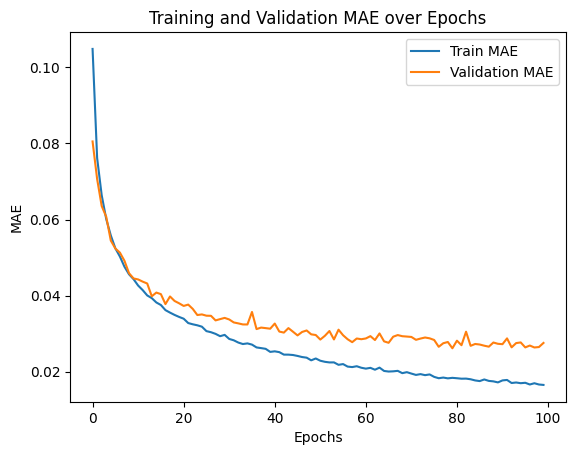

In [32]:
if path_to_current_model == "none":
    train_mae = history.history["mae"]
    val_mae = history.history["val_mae"]
    plt.figure()
    plt.plot(train_mae, label='Train MAE')
    plt.plot(val_mae, label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE over Epochs')
    plt.legend()

In [33]:
if path_to_current_model == "none":
    import json
    with open(new_model_path[:-6] +'_history.json', 'w') as f:
        json.dump(history.history, f)